In [ ]:
import pandas as pd
import requests
import io
import zipfile

print("--- Iniciando carga de datos desde GitHub ---")

# --- Tus 3 URLs de GitHub ---
url_2005_zip = 'https://github.com/mwroclavsky/CC408-Grupo-T3-13/raw/refs/heads/main/usu_individual_t105.zip'
url_2025_xlsx = 'https://github.com/mwroclavsky/CC408-Grupo-T3-13/raw/refs/heads/main/usu_individual_T125.xlsx'
url_equiv_xlsx = 'https://github.com/mwroclavsky/CC408-Grupo-T3-13/raw/refs/heads/main/tabla_adulto_equiv.xlsx'

# --- 1. Cargar datos 2005 (desde ZIP) ---
try:
    print(f"\nCargando y descomprimiendo archivo 2005 (zip) desde:\n{url_2005_zip}")

    # Descargar el contenido del .zip
    r = requests.get(url_2005_zip)

    # Abrir el .zip en memoria
    z = zipfile.ZipFile(io.BytesIO(r.content))

    # Encontrar el nombre del archivo .dta dentro del .zip
    # (Asumimos que solo hay un archivo .dta)
    dta_filename = [f for f in z.namelist() if f.endswith('.dta')][0]
    print(f"Extrayendo '{dta_filename}' desde el .zip...")

    # Abrir el archivo .dta y cargarlo en pandas
    with z.open(dta_filename) as f:
        df05 = pd.read_stata(f)

    print("¡ÉXITO! Archivo 2005 (dta desde zip) cargado.")
    print(df05.head())

except Exception as e:
    print(f"\nERROR al leer el archivo 2005 (zip): {e}")

# --- 2. Cargar datos 2025 (Excel) ---
try:
    print(f"\nCargando archivo 2025 (xlsx) desde:\n{url_2025_xlsx}")

    df25 = pd.read_excel(url_2025_xlsx)

    print("¡ÉXITO! Archivo 2025 (xlsx) cargado.")
    print(df25.head())

except Exception as e:
    print(f"\nERROR al leer el archivo 2025: {e}")

# --- 3. Cargar Tabla Adulto Equivalente (Excel) ---
try:
    print(f"\nCargando Tabla Adulto Equivalente (xlsx) desde:\n{url_equiv_xlsx}")

    # Mantenemos el skiprows=3 que tenías, asumiendo que el formato es el mismo
    df_adulto_equiv = pd.read_excel(url_equiv_xlsx, skiprows=3)

    # Renombramos columnas para que sea fácil usarlas (mismo código que tenías)
    df_adulto_equiv = df_adulto_equiv.rename(columns={
        'Edad': 'edad_str',
        'Mujeres': 'mujer_equiv',
        'Varones': 'varon_equiv'
    })

    print("¡ÉXITO! Tabla Adulto Equivalente (xlsx) cargada y limpia.")
    print(df_adulto_equiv.head())

except Exception as e:
    print(f"\nERROR al leer la tabla de equivalencia: {e}")

print("\n--- Carga de datos finalizada ---")

--- Iniciando carga de datos desde GitHub ---

Cargando y descomprimiendo archivo 2005 (zip) desde:
https://github.com/mwroclavsky/CC408-Grupo-T3-13/raw/refs/heads/main/usu_individual_t105.zip
Extrayendo 'usu_individual_t105.dta' desde el .zip...
¡ÉXITO! Archivo 2005 (dta desde zip) cargado.
     CODUSU  nro_hogar componente  h15    ano4       trimestre  \
0  125098          1.0        1.0   Sí  2005.0  1er. Trimestre   
1  125188          1.0        1.0   Sí  2005.0  1er. Trimestre   
2  125188          1.0        2.0   Sí  2005.0  1er. Trimestre   
3  125188          1.0        3.0  0.0  2005.0  1er. Trimestre   
4  125242          1.0        1.0   Sí  2005.0  1er. Trimestre   

              region mas_500              aglomerado  pondera  ... deccfr  \
0  Gran Buenos Aires       S  Ciudad de Buenos Aires   1017.0  ...     08   
1  Gran Buenos Aires       S  Ciudad de Buenos Aires   1062.0  ...     02   
2  Gran Buenos Aires       S  Ciudad de Buenos Aires   1062.0  ...     02   
3 

In [ ]:
# ----- INICIO BLOQUE 2 (Filtrar Patagonia) [CORREGIDO x3] -----

# Primero, chequeamos que las variables del paso anterior existan
if 'df05' not in locals() or 'df25' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontraron los DataFrames 'df05' o 'df25'.")
    print("Por favor, asegurate de ejecutar la celda anterior (la que carga los archivos) con éxito.")
    print("---------------------------------------------------------------")
else:
    print("DataFrames 'df05' y 'df25' encontrados. Empezando limpieza...")

    # Pongo mismo nombre de columnas (region)
    df05.columns = [c.strip().lower() for c in df05.columns]
    df25.columns = [c.strip().lower() for c in df25.columns]
    print("Columnas pasadas a minúsculas.")

    # --- INICIO DE LA FUNCIÓN "LIMPIA" ---

    def filtrar_patagonia(df, col_region="region"):
        # Esta sangría está hecha con espacios normales (ASCII 32)
        if col_region.strip() not in df.columns:
            if col_region.upper() in df.columns:
                 raise ValueError(f"Error: La columna '{col_region}' no se encontró. ¿Quizás faltó correr la línea .columns.lower()?")
            else:
                 raise ValueError(f"No se encontró la columna '{col_region}' en el DataFrame.")

        s = df[col_region]
        mask = (
            s.astype(str).str.upper().eq("PATAGÓNICA") |     # caso texto (2005)
            pd.to_numeric(s, errors="coerce").eq(44)         # caso código (2025)
        )
        return df.loc[mask].copy()

    # --- FIN DE LA FUNCIÓN "LIMPIA" ---

    # Aplico el filtro
    pat05 = filtrar_patagonia(df05, "region")
    pat25 = filtrar_patagonia(df25, "region")
    print("Filtro de Patagonia aplicado.")

    # Chequeos rápidos (cantidad de filas y columnas)
    print("\n----- 2005 -----")
    print("Filas totales:", len(df05), " | Filas Patagonia:", len(pat05))
    print("Columnas totales:", len(df05.columns))
    # --- ¡¡AQUÍ ESTÁ LA CORRECCIÓN!! ---
    print("Columnas después del filtro:", len(pat05.columns)) # <-- Era pat0ac, ahora es pat05

    print("\n----- 2025 -----")
    print("Filas totales:", len(df25), " | Filas Patagonia:", len(pat25))
    print("Columnas totales:", len(df25.columns))
    print("Columnas después del filtro:", len(pat25.columns))

    print("\nEjemplo valores únicos de 'region' en 2005:", pat05["region"].unique()[:5])
    print("Ejemplo valores únicos de 'region' en 2025:", pat25["region"].unique()[:5])

    print("Regiones únicas en 2005 filtradas:", pat05["region"].unique())
    print("Regiones únicas en 2025 filtradas:", pat25["region"].unique())

# ----- FIN BLOQUE 2 -----

DataFrames 'df05' y 'df25' encontrados. Empezando limpieza...
Columnas pasadas a minúsculas.
Filtro de Patagonia aplicado.

----- 2005 -----
Filas totales: 47030  | Filas Patagonia: 3229
Columnas totales: 176
Columnas después del filtro: 176

----- 2025 -----
Filas totales: 45425  | Filas Patagonia: 5359
Columnas totales: 235
Columnas después del filtro: 235

Ejemplo valores únicos de 'region' en 2005: ['Patagónica']
Categories (6, object): ['Gran Buenos Aires' < 'NOA' < 'NEA' < 'Cuyo' < 'Pampeana' < 'Patagónica']
Ejemplo valores únicos de 'region' en 2025: [44]
Regiones únicas en 2005 filtradas: ['Patagónica']
Categories (6, object): ['Gran Buenos Aires' < 'NOA' < 'NEA' < 'Cuyo' < 'Pampeana' < 'Patagónica']
Regiones únicas en 2025 filtradas: [44]


In [ ]:
# ----- INICIO BLOQUE 3 (Diccionarios) -----

# Importamos (aunque ya deberían estar importados, no hace mal)
import numpy as np
import pandas as pd

# --- 0) Variables de interés ---
# (La re-escribí en una sola línea para evitar errores de espacios)
cols_interes = [
    "ch04", "ch06", "ch07", "ch08", "nivel_ed", "estado", "cat_inac",
    "ipcf", "ch15", "ch09", "pp10a", "pp3e_tot", "pp07a", "pp10e", "cat_ocup"
]

# --- 1) Diccionarios (Con sangrías "limpias") ---

est_civil = {"Unido": 1, "Casado": 2, "Separado o divorciado": 3, "Viudo": 4, "Soltero": 5, "Ns./Nr.": 9}

cob_medica = {
    "Obra social (incluye PAMI)": 1,
    "Mutual/Prepaga/Servicio de emergencia": 2,
    "Planes y seguros públicos": 3,
    "No paga ni le descuentan": 4,
    "Ns./Nr.": 9,
    "Obra social y mutual/prepaga/servicio de emergencia": 12,
    "Obra social y planes y seguros públicos": 13,
    "Mutual/prepaga/servicio de emergencia/planes y seguros públicos": 23,
    "Obra social, mutual/prepaga/servicio de emergencia y Planes y Seguros Públicos": 123
}

alfab = {"Sí": 1, "No": 2, "Menor de 2 años": 3, "Ns./Nr.": 9, 0.0: np.nan}

nivel_ed_map = {
    "Primaria Incompleta": 1, "Primaria Completa": 2, "Secundaria Incompleta": 3, "Secundaria Completa": 4,
    "Superior Universitaria Incompleta": 5, "Superior Universitaria Completa": 6, "Sin instrucción": 7,
    "Ns./Nr": 9, "Ns./Nr.": 9
}

cond_act = {
    "Entrevista individual no realizada (no respuesta al cuestion)": 0,
    "Ocupado": 1, "Desocupado": 2, "Inactivo": 3, "Menor de 10 años": 4
}

inactividad = {
    "Jubilado/pensionado": 1, "Rentista": 2, "Estudiante": 3, "Ama de casa": 4,
    "Menor de 6 años": 5, "Discapacitado": 6, "Otros": 7, 0.0: np.nan
}

nacimiento = {
    "En esta localidad": 1, "En otra localidad": 2, "En otra provincia (especificar)": 3,
    "En un país limítrofe": 4, "En otro país": 5, "Ns./Nr": 9, "Ns./Nr.": 9
}

busca_trab = {
    "...menos de 1 mes?": 1, "...de 1 a 3 meses?": 2, "...más de 3 a 6 meses?": 3,
    "...más de 6 a 12 meses?": 4, "...más de 1 año?": 5
}

tiempo_trabajando = {
    "Menos de un mes": 1, "1 a 3 meses": 2, "Más de 3 a 6 meses": 3,
    "Más de 6 a 12 meses": 4, "Más de 1 a 5 años": 5, "Más de 5 años": 6, "Ns./Nr.": 9
}

tiempo_desocupado = {
    "...menos de 1 mes?": 1, "...de 1 a 3 meses?": 2, "...más de 3 a 6 meses?": 3,
    "...más de 6 a 12 meses?": 4, "...más de 1 a 3 años?": 5, "...más de 3 años?": 6
}

cat_ocup_map = {
    "Patrón": 1, "Cuenta propia": 2, "Obrero o empleado": 3,
    "Trabajador familiar sin remuneración": 4, 0.0: np.nan
}

# --- Chequeo final ---
print("¡ÉXITO! Bloque 3 ejecutado.")
print(f"Se creó la lista 'cols_interes' con {len(cols_interes)} variables.")
print(f"Se creó el diccionario 'est_civil'. Ejemplo: 'Unido' es {est_civil['Unido']}")
print(f"Se creó el diccionario 'cat_ocup_map'. Ejemplo: 'Patrón' es {cat_ocup_map['Patrón']}")

# ----- FIN BLOQUE 3 -----

¡ÉXITO! Bloque 3 ejecutado.
Se creó la lista 'cols_interes' con 15 variables.
Se creó el diccionario 'est_civil'. Ejemplo: 'Unido' es 1
Se creó el diccionario 'cat_ocup_map'. Ejemplo: 'Patrón' es 1


In [ ]:
# ----- INICIO BLOQUE 4 (Recodificación y Fusión) -----

# Chequeo de seguridad:
# Verificamos que existan las tablas del Bloque 2 ('pat05')
# y los diccionarios del Bloque 3 ('est_civil')
if 'pat05' not in locals() or 'pat25' not in locals() or 'est_civil' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontraron 'pat05', 'pat25' o los diccionarios.")
    print("Por favor, asegurate de ejecutar los Bloques 2 y 3 con éxito ANTES de correr esta celda.")
    print("---------------------------------------------------------------")
else:
    print("Dependencias OK. Empezando recodificación...")

    # --- Tu código (limpiado de espacios) ---

    sexo_map = {"Varón": 1, "Mujer": 2}

    pat05_num = pat05.copy()

    # Aplicamos los diccionarios (del Bloque 3) a la base 2005
    pat05_num["ch04"] = pat05_num["ch04"].map(sexo_map)
    pat05_num["ch07"] = pat05_num["ch07"].map(est_civil)
    pat05_num["ch08"] = pat05_num["ch08"].map(cob_medica)
    pat05_num["nivel_ed"] = pat05_num["nivel_ed"].map(nivel_ed_map)
    pat05_num["estado"] = pat05_num["estado"].map(cond_act)
    pat05_num["cat_inac"] = pat05_num["cat_inac"].map(inactividad)
    pat05_num["ch15"] = pat05_num["ch15"].map(nacimiento)
    pat05_num["ch09"] = pat05_num["ch09"].map(alfab)
    pat05_num["pp10a"] = pat05_num["pp10a"].map(busca_trab)
    pat05_num["pp07a"] = pat05_num["pp07a"].map(tiempo_trabajando)
    pat05_num["pp10e"] = pat05_num["pp10e"].map(tiempo_desocupado)
    pat05_num["cat_ocup"] = pat05_num["cat_ocup"].map(cat_ocup_map)

    print("Mapeo de la base 2005 completado.")

    # --- Definición de 'cols_interes' (¡OJO CON LOS ESPACIOS!) ---
    # (Te la re-escribí para que sea segura)
    cols_interes = [
        "ch04", "ch06", "ch07", "ch08", "nivel_ed", "estado", "cat_inac",
        "ipcf", "ch15", "ch09", "pp10a", "pp3e_tot", "pp07a", "pp10e", "cat_ocup",
        "ano4"  # <-- Esta es la columna que agregó tu tutor
    ]

    # --- IMPORTANTE: ANTES DE SUBSET, COPIAR pat25 ---
    # Tu código original selecciona 'cols_interes' de 'pat25'
    # pero no lo copia, lo que puede dar un 'SettingWithCopyWarning'.
    # Es mejor crear 'pat25_num' como una copia limpia.
    pat25_num = pat25.copy()

    # Seleccionamos solo las columnas de interés
    pat05_num = pat05_num[cols_interes]
    pat25_num = pat25_num[cols_interes]

    print("Columnas seleccionadas para ambas bases.")

    # Unimos las bases
    patagonia_filtrada = pd.concat([pat05_num, pat25_num], axis=0, ignore_index=True)

    print("\n¡¡¡ÉXITO TOTAL!!!")
    print(f"Se creó la base 'patagonia_filtrada' con {patagonia_filtrada.shape[0]} filas y {patagonia_filtrada.shape[1]} columnas.")
    print("\nAños en la base unificada:")
    print(patagonia_filtrada['ano4'].value_counts())

    print("\n--- Muestra de la base final ---")
    print(patagonia_filtrada.head())

# ----- FIN BLOQUE 4 -----

Dependencias OK. Empezando recodificación...
Mapeo de la base 2005 completado.
Columnas seleccionadas para ambas bases.

¡¡¡ÉXITO TOTAL!!!
Se creó la base 'patagonia_filtrada' con 8588 filas y 16 columnas.

Años en la base unificada:
ano4
2025.0    5359
2005.0    3229
Name: count, dtype: int64

--- Muestra de la base final ---
   ch04  ch06  ch07  ch08  nivel_ed  estado  cat_inac   ipcf  ch15  ch09  \
0     1  46.0     2   1.0       3.0     1.0       NaN  480.0     3   1.0   
1     2  32.0     2   1.0       3.0     3.0       4.0  480.0     3   1.0   
2     1  14.0     5   1.0       2.0     3.0       3.0  480.0     3   1.0   
3     1   9.0     5   1.0       NaN     4.0       3.0  480.0     1   1.0   
4     2   3.0     5   1.0       7.0     4.0       5.0  480.0     1   2.0   

   pp10a  pp3e_tot  pp07a  pp10e  cat_ocup    ano4  
0    NaN      48.0    6.0    NaN       3.0  2005.0  
1    NaN       0.0    NaN    NaN       NaN  2005.0  
2    NaN       0.0    NaN    NaN       NaN  2005.0  
3 

=== Tabla de faltantes por año ===
          2005  2025
ch04         0     0
ch06         0     0
ch07         0     0
ch08         0     0
nivel_ed   692     0
estado       2     0
cat_inac  1385     0
ipcf         0     0
ch15         0     0
ch09         1     0
pp10a     3127  5237
pp3e_tot     0  3036
pp07a     2226  3036
pp10e     3139  5237
cat_ocup  1868     0
ano4         0     0

¡ÉXITO! Heatmap guardado como 'heatmap_faltantes.png'.

Top variables con más faltantes en 2005:
pp10e       3139
pp10a       3127
pp07a       2226
cat_ocup    1868
cat_inac    1385
Name: 2005, dtype: int64

Top variables con más faltantes en 2025:
pp10e       5237
pp10a       5237
pp3e_tot    3036
pp07a       3036
ch04           0
Name: 2025, dtype: int64


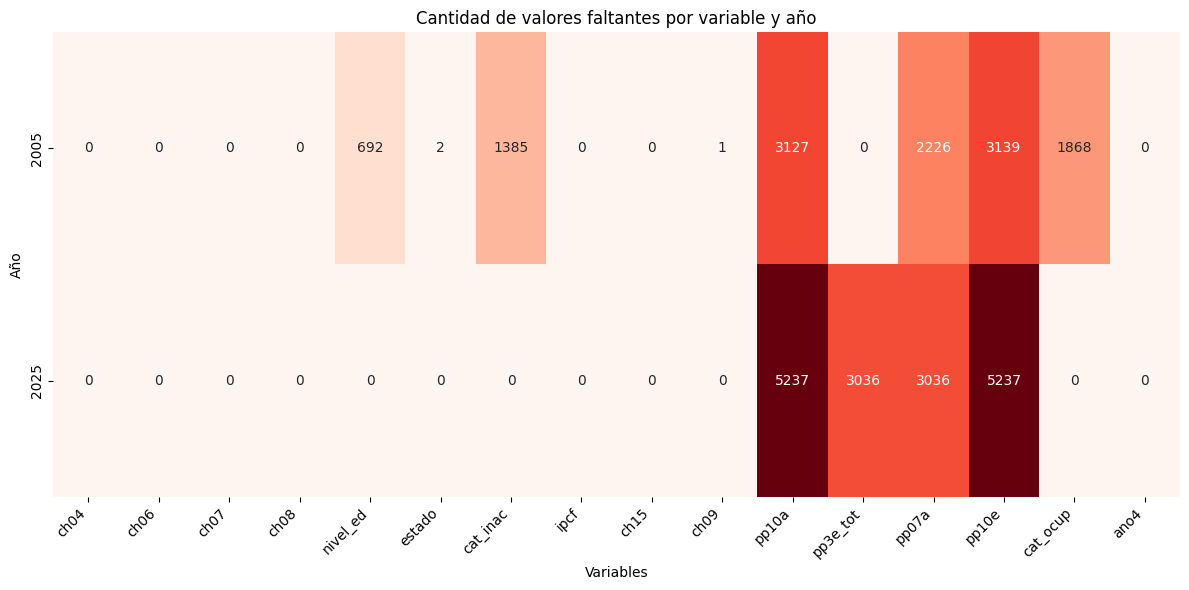

In [ ]:
# ----- INICIO BLOQUE 2b (Heatmap Faltantes) -----

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chequeo de seguridad:
# Verificamos que existan las tablas del Bloque 4 ('pat05_num' y 'pat25_num')
if 'pat05_num' not in locals() or 'pat25_num' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontraron 'pat05_num' o 'pat25_num'.")
    print("Por favor, asegurate de ejecutar los bloques anteriores con éxito ANTES de correr esta celda.")
    print("---------------------------------------------------------------")
else:
    # --- Tu código (100% compatible) ---

    #Paso 2. Contar valores faltantes por variable
    na_2005 = pat05_num.isna().sum()
    na_2025 = pat25_num.isna().sum()

    na_summary = pd.DataFrame({"2005": na_2005, "2025": na_2025})
    print("=== Tabla de faltantes por año ===")
    print(na_summary)

    #Paso 3. Heatmap
    # (Tu código de plot, 100% compatible)
    plt.figure(figsize=(12, 6))
    sns.heatmap(na_summary.T, annot=True, fmt="d", cmap="Reds", cbar=False)
    plt.title("Cantidad de valores faltantes por variable y año")
    plt.xlabel("Variables")
    plt.ylabel("Año")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # --- ¡¡EL CAMBIO ESTÁ ACÁ!! ---
    # En lugar de plt.show(), lo guardamos en un archivo
    try:
        plt.savefig('heatmap_faltantes.png')
        print("\n¡ÉXITO! Heatmap guardado como 'heatmap_faltantes.png'.")
    except Exception as e:
        print(f"\nERROR: No se pudo guardar el gráfico: {e}")
    # plt.show() # Ya no lo necesitamos si lo guardamos

    #Paso 4. Identificar cuáles tienen más faltantes
    # (Tu código 100% compatible)
    print("\nTop variables con más faltantes en 2005:")
    print(na_summary["2005"].sort_values(ascending=False).head())

    print("\nTop variables con más faltantes en 2025:")
    print(na_summary["2025"].sort_values(ascending=False).head())

    # --- Tus notas (convertidas a comentarios) ---
    # En la comparación de 2005 y 2025, se observa que las variables con más valores faltantes de 2005 son ch04, ch07, ch08, ch015 y estado,
    # donde concentran 16.145 casos. En cuanto al 2025,se observa que las variables con más valores faltantes son pp10a, pp10e, pp07a, pp3e_tot
    # que concentran 16.546 casos. El resto de las variables presentan muy pocos o ningún valor perdido. Esto sugiere que la calidad de los
    # datos es mayor en las variables básicas (como sexo o edad), mientras que la información más sensible (como ingresos o cobertura médica)
    # presenta mayores problemas de no respuesta.

# ----- FIN BLOQUE 2b -----

In [ ]:
# ----- INICIO BLOQUE 2c (Limpieza de Atípicos y Válidos) -----

import numpy as np

# Chequeo de seguridad:
# Verificamos que exista la tabla del Bloque 4 ('patagonia_filtrada')
if 'patagonia_filtrada' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontró 'patagonia_filtrada'.")
    print("Por favor, asegurate de ejecutar el Bloque 4 (fusión) con éxito ANTES de correr esta celda.")
    print("---------------------------------------------------------------")
else:
    # --- Tu código (limpiado de espacios) ---

    # Copiar la base para no pisar el original
    patagonia_limpia = patagonia_filtrada.copy()
    print("DataFrame 'patagonia_filtrada' copiado a 'patagonia_limpia'.")

    # 1. Ingresos negativos -> NaN: nunca deberían ser negativos.
    count_ipcf = (patagonia_limpia["ipcf"] < 0).sum()
    if count_ipcf > 0:
        print(f"Se encontraron {count_ipcf} ingresos negativos ('ipcf'). Pasando a NaN...")
    patagonia_limpia.loc[patagonia_limpia["ipcf"] < 0, "ipcf"] = np.nan

    # 2. Horas de trabajo fuera de rango razonable (ej. <0 o >100) -> NaN
    mask_horas = (patagonia_limpia["pp3e_tot"] < 0) | (patagonia_limpia["pp3e_tot"] > 100)
    count_horas = mask_horas.sum()
    if count_horas > 0:
        print(f"Se encontraron {count_horas} valores de horas ('pp3e_tot') fuera de rango. Pasando a NaN...")
    patagonia_limpia.loc[mask_horas, "pp3e_tot"] = np.nan

    # 3. Reglas de validación por categorías
    # (¡AQUÍ ESTÁ EL ARREGLO! Sangrías re-escritas para evitar SyntaxError)
    valid_ranges = {
        "ch04": [1, 2],
        "ch07": [1, 2, 3, 4, 5],
        "ch08": [1, 2, 3, 4, 9, 12, 13, 23, 123],
        "nivel_ed": [1, 2, 3, 4, 5, 6, 7, 9],
        "estado": [0, 1, 2, 3, 4],
        "cat_inac": [1, 2, 3, 4, 5, 6, 7],
        "ch15": [1, 2, 3, 4, 5, 9],
        "ch09": [1, 2, 3],
        "pp10a": [1, 2, 3, 4, 5],
        "pp07a": [1, 2, 3, 4, 5, 6, 9],
        "pp10e": [1, 2, 3, 4, 5, 6],
        "cat_ocup": [1, 2, 3, 4]
    }

    print("\nAplicando reglas de validación por rangos...")
    # (Sangría del loop re-escrita también)
    for col, valid_vals in valid_ranges.items():
        # Contamos cuántos valores vamos a anular ANTES de hacerlo
        count_invalid = (~patagonia_limpia[col].isin(valid_vals) & patagonia_limpia[col].notna()).sum()
        if count_invalid > 0:
            print(f"   - En '{col}', se anularán {count_invalid} valores inválidos.")

        # Aplicamos la limpieza
        patagonia_limpia.loc[~patagonia_limpia[col].isin(valid_vals), col] = np.nan

    print("\n¡Limpieza de rangos completada!")
    print("\n--- Valores faltantes DESPUÉS de limpieza (Top 10) ---")
    print(patagonia_limpia.isna().sum().sort_values(ascending=False).head(10))

    # --- Tus notas (convertidas a comentarios) ---
    # Durante la etapa de limpieza se corrigieron valores fuera de rango en las variables seleccionadas. En particular, se reemplazaron como
    # faltantes los ingresos negativos en ipcf y las horas semanales de trabajo menores a 0 o mayores a 100 en pp3e_tot. Asimismo, se
    # recodificaron como NaN aquellas categorías que aparecían fuera de los valores válidos definidos por la codificación de la EPH
    # (por ejemplo, códigos no reconocidos en estado civil, cobertura médica o nivel educativo). Este proceso asegura que los análisis
    # posteriores se realicen únicamente con datos consistentes.

# ----- FIN BLOQUE 2c -----

DataFrame 'patagonia_filtrada' copiado a 'patagonia_limpia'.
Se encontraron 4 valores de horas ('pp3e_tot') fuera de rango. Pasando a NaN...

Aplicando reglas de validación por rangos...
   - En 'cat_inac', se anularán 2456 valores inválidos.
   - En 'ch09', se anularán 1 valores inválidos.
   - En 'pp07a', se anularán 599 valores inválidos.
   - En 'pp10e', se anularán 19 valores inválidos.
   - En 'cat_ocup', se anularán 2943 valores inválidos.

¡Limpieza de rangos completada!

--- Valores faltantes DESPUÉS de limpieza (Top 10) ---
pp10e       8395
pp10a       8364
pp07a       5861
cat_ocup    4811
cat_inac    3841
pp3e_tot    3040
nivel_ed     692
estado         2
ch09           2
ipcf           0
dtype: int64


Generando nuevo heatmap con la base 'patagonia_limpia'...

=== Tabla de faltantes por año (POST-LIMPIEZA) ===
          2005  2025
ch04         0     0
ch06         0     0
ch07         0     0
ch08         0     0
nivel_ed   692     0
estado       2     0
cat_inac  1385  2456
ipcf         0     0
ch15         0     0
ch09         1     1
pp10a     3127  5237
pp3e_tot     2  3038
pp07a     2226  3635
pp10e     3139  5256
cat_ocup  1868  2943
ano4         0     0

¡ÉXITO! Heatmap guardado como 'heatmap_faltantes_LIMPIA.png'.

Top variables con más faltantes en 2005 (POST-LIMPIEZA):
pp10e       3139
pp10a       3127
pp07a       2226
cat_ocup    1868
cat_inac    1385
Name: 2005, dtype: int64

Top variables con más faltantes en 2025 (POST-LIMPIEZA):
pp10e       5256
pp10a       5237
pp07a       3635
pp3e_tot    3038
cat_ocup    2943
Name: 2025, dtype: int64


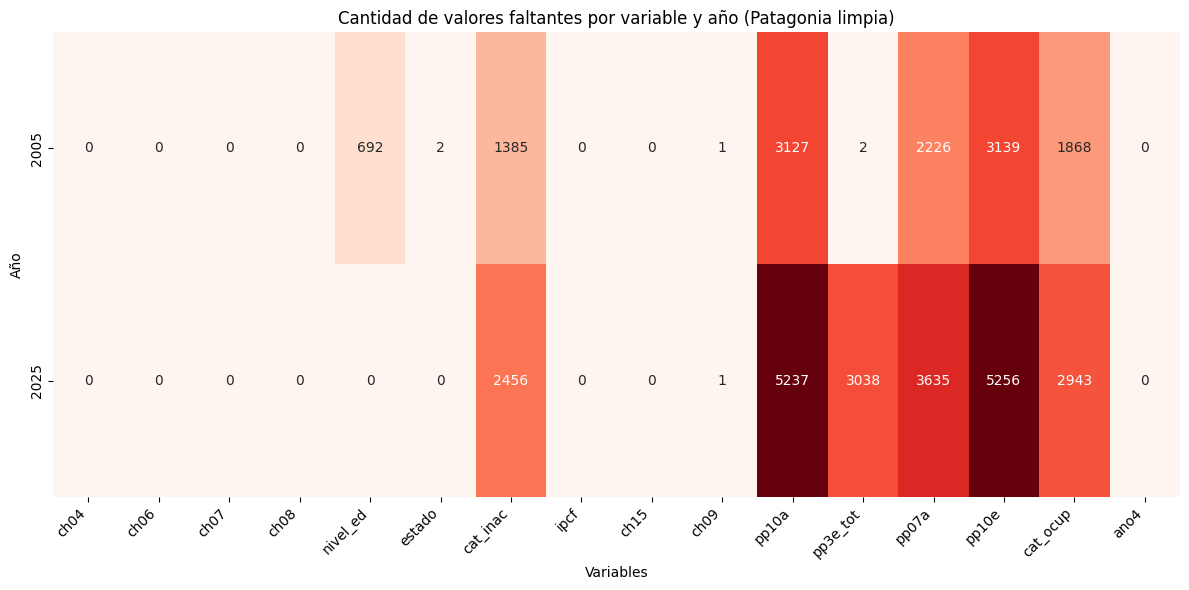

In [ ]:
# ----- INICIO BLOQUE 2c (Heatmap #2 - Base Limpia) -----

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chequeo de seguridad:
# Verificamos que exista la tabla del Bloque 2c ('patagonia_limpia')
if 'patagonia_limpia' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontró 'patagonia_limpia'.")
    print("Por favor, asegurate de ejecutar el Bloque 2c (limpieza) con éxito ANTES de correr esta celda.")
    print("---------------------------------------------------------------")
else:
    # --- Tu código (100% compatible) ---
    print("Generando nuevo heatmap con la base 'patagonia_limpia'...")

    # Separamos por año la base LIMPIA
    pat05_num = patagonia_limpia[patagonia_limpia["ano4"] == 2005]
    pat25_num = patagonia_limpia[patagonia_limpia["ano4"] == 2025]

    # Contamos faltantes
    na_2005 = pat05_num.isna().sum()
    na_2025 = pat25_num.isna().sum()

    na_summary = pd.DataFrame({"2005": na_2005, "2025": na_2025})
    print("\n=== Tabla de faltantes por año (POST-LIMPIEZA) ===")
    print(na_summary)

    # Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(na_summary.T, annot=True, fmt="d", cmap="Reds", cbar=False)
    plt.title("Cantidad de valores faltantes por variable y año (Patagonia limpia)")
    plt.xlabel("Variables")
    plt.ylabel("Año")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # --- ¡¡EL CAMBIO ESTÁ ACÁ!! ---
    # En lugar de plt.show(), lo guardamos en un archivo
    try:
        # Le ponemos un nombre nuevo para no pisar el anterior
        plt.savefig('heatmap_faltantes_LIMPIA.png')
        print("\n¡ÉXITO! Heatmap guardado como 'heatmap_faltantes_LIMPIA.png'.")
    except Exception as e:
        print(f"\nERROR: No se pudo guardar el gráfico: {e}")
    # plt.show() # No es necesario

    # Top faltantes (POST-LIMPIEZA)
    print("\nTop variables con más faltantes en 2005 (POST-LIMPIEZA):")
    print(na_summary["2005"].sort_values(ascending=False).head())

    print("\nTop variables con más faltantes en 2025 (POST-LIMPIEZA):")
    print(na_summary["2025"].sort_values(ascending=False).head())

# ----- FIN BLOQUE 2c (Heatmap #2) -----

Base 'patagonia_limpia' encontrada. Generando gráfico de 'Consigna 3'...

Tabla de composición por sexo en 2005 y 2025:

Sexo    Mujer  Varón
ano4                
2005.0   1654   1575
2025.0   2709   2650

¡ÉXITO! Gráfico guardado como 'grafico_sexo_consigna3.png'.


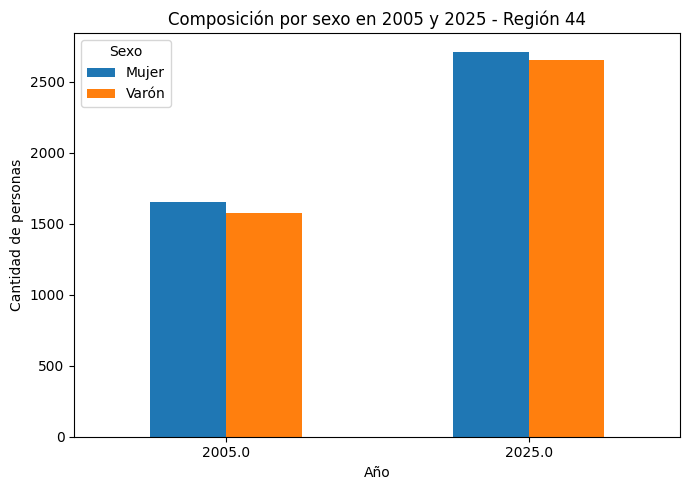

In [ ]:
# ----- INICIO BLOQUE 'Consigna 3' (Gráfico Sexo) -----

import pandas as pd
import matplotlib.pyplot as plt

# Chequeo de seguridad:
# Verificamos que exista la tabla del Bloque 2c ('patagonia_limpia')
if 'patagonia_limpia' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontró 'patagonia_limpia'.")
    print("Por favor, asegurate de ejecutar el Bloque 2c (limpieza) con éxito ANTES de correr esta celda.")
    print("---------------------------------------------------------------")
else:
    print("Base 'patagonia_limpia' encontrada. Generando gráfico de 'Consigna 3'...")

    # --- Tu código (con sangrías "limpias") ---

    # 1) Armo tabla: filas = año, columnas = sexo
    sexo_labels = {1: "Varón", 2: "Mujer"}

    # (¡AQUÍ ESTÁ EL ARREGLO! Sangrías re-escritas para evitar SyntaxError)
    tabla = (
        patagonia_limpia
        .assign(Sexo=patagonia_limpia["ch04"].map(sexo_labels))
        .groupby(["ano4", "Sexo"])
        .size()
        .unstack("Sexo")
        .fillna(0)
        .astype(int)
        .sort_index()
    )

    print("\nTabla de composición por sexo en 2005 y 2025:\n")
    print(tabla)

    # 2) Gráfico: barras agrupadas por año (X = años)
    # (Sangrías "limpias" aquí también)
    ax = tabla.plot(kind="bar", figsize=(7, 5))
    ax.set_title("Composición por sexo en 2005 y 2025 - Región 44")
    ax.set_xlabel("Año")
    ax.set_ylabel("Cantidad de personas")
    ax.legend(title="Sexo")
    plt.xticks(rotation=0)
    plt.tight_layout()

    # --- ¡¡EL CAMBIO ESTÁ ACÁ!! ---
    # En lugar de plt.show(), lo guardamos en un archivo
    try:
        plt.savefig('grafico_sexo_consigna3.png')
        print("\n¡ÉXITO! Gráfico guardado como 'grafico_sexo_consigna3.png'.")
    except Exception as e:
        print(f"\nERROR: No se pudo guardar el gráfico: {e}")
    # plt.show() # No es necesario

# ----- FIN BLOQUE 'Consigna 3' -----

Base 'patagonia_limpia' encontrada. Empezando 'Consigna 4'...
Limpiando columna 'ch06' (Edad)...
Separando bases por año...
Definiendo función 'preparar_base' para crear dummies...
Procesando base 2005...
Procesando base 2025...
Matrices de correlación calculadas (33 variables).

--- ¡ADVERTENCIA! ---
Estás a punto de crear un heatmap de 33x33 variables con 'annot=True'.
Esto puede ser ILEGIBLE y tardar mucho. Si sale mal, cambiá 'annot=True' por 'annot=False'.

Generando heatmap 2005...


/tmp/ipython-input-1032876510.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  patagonia_limpia['Edad'] = patagonia_limpia['ch06'].replace({


¡ÉXITO! Heatmap 2005 guardado como 'corr_heatmap_2005.png'.

Generando heatmap 2025...
¡ÉXITO! Heatmap 2025 guardado como 'corr_heatmap_2025.png'.

Comentario:
La matriz de correlación para Patagonia en 2005 y 2025 muestra cómo se relacionan las variables demográficas y laborales. Se observa una correlación positiva entre el nivel educativo y los ingresos, y entre la condición de actividad y el ingreso, lo que indica que personas con mayor educación y en actividad tienden a tener mejores ingresos. El sexo muestra baja correlación con el ingreso, lo que sugiere brecha moderada. Ciertas causas de inactividad y algunas coberturas médicas presentan correlaciones negativas con el empleo y los ingresos, evidenciando exclusión en ciertos grupos. Los patrones se mantienen estables entre 2005 y 2025, aunque puede haber variaciones menores por cambios sociales y económicos. El análisis sintético permite visualizar las conexiones entre educación, mercado laboral y estructura social en la región.


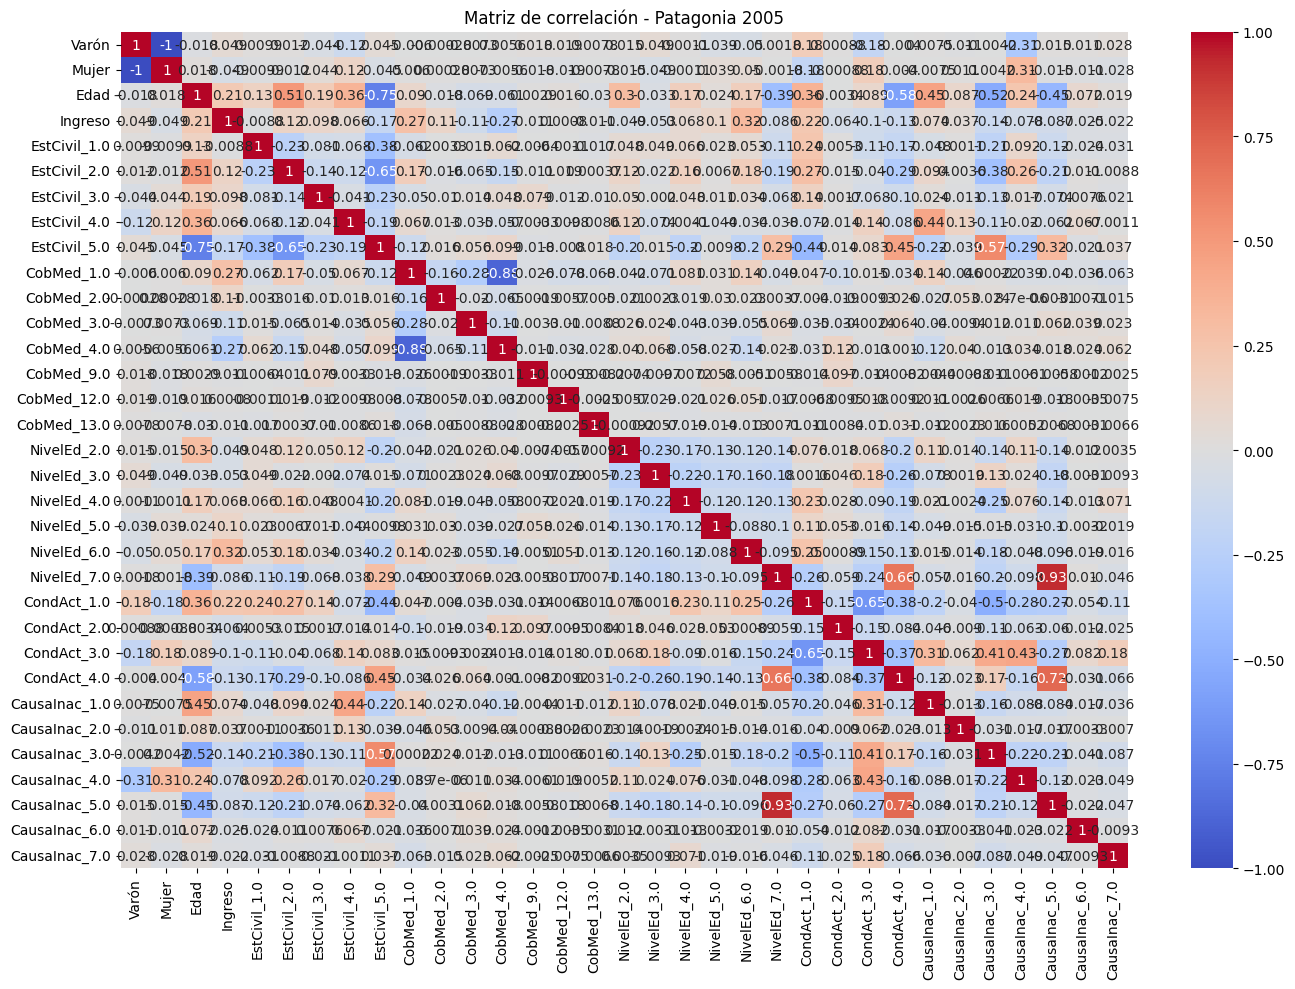

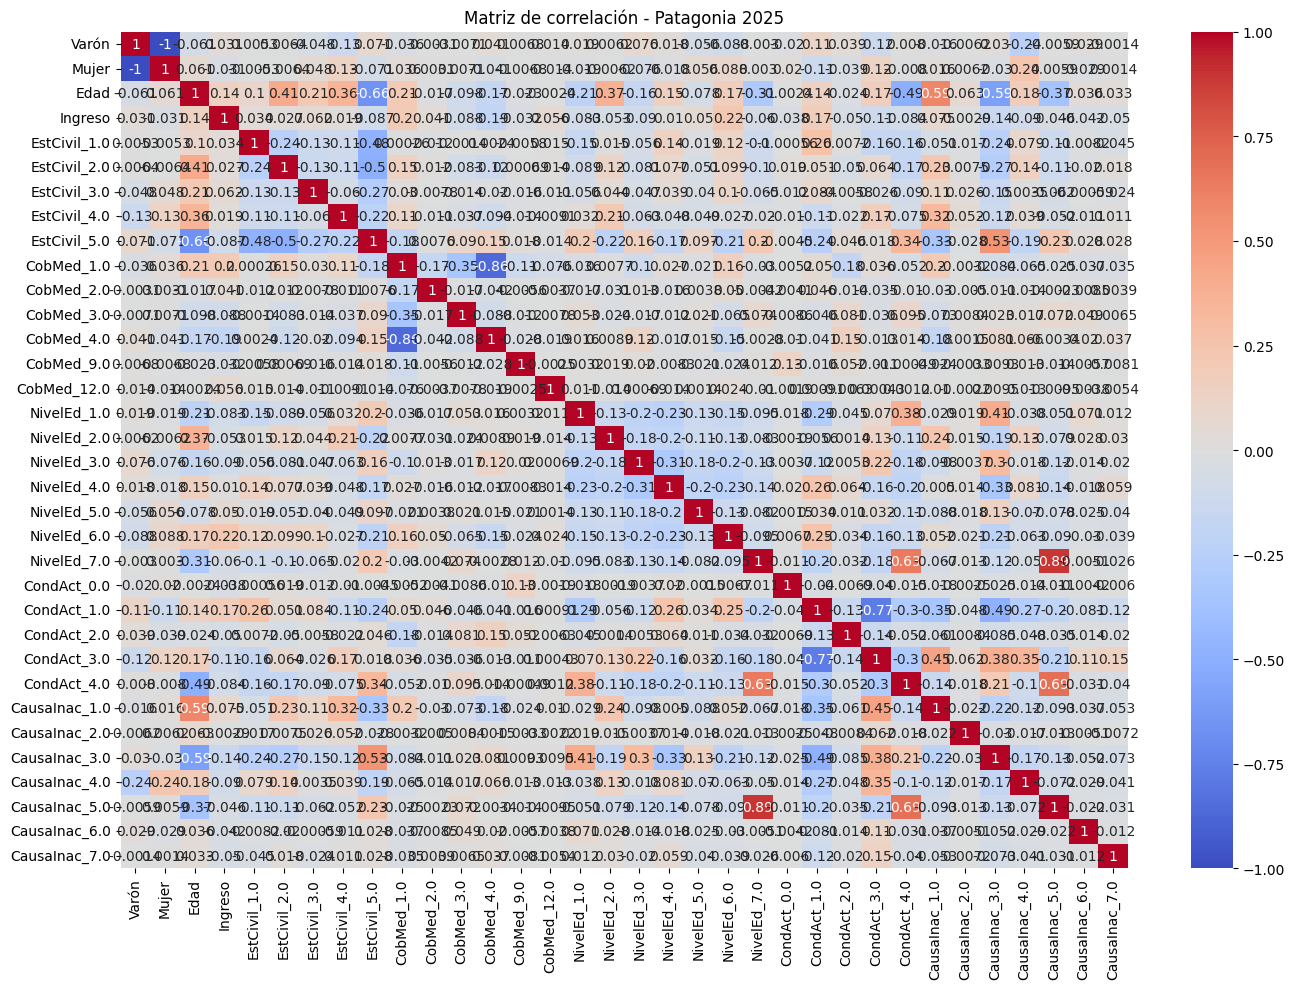

In [ ]:
# ----- INICIO BLOQUE 'Consigna 4' (Heatmap Correlación) -----

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chequeo de seguridad:
if 'patagonia_limpia' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontró 'patagonia_limpia'.")
    print("Por favor, asegurate de ejecutar el Bloque 2c (limpieza) con éxito ANTES de correr esta celda.")
    print("---------------------------------------------------------------")
else:
    print("Base 'patagonia_limpia' encontrada. Empezando 'Consigna 4'...")

    # --- 1. Limpieza robusta de la columna edad (ch06) ---
    # (¡AQUÍ ESTÁ EL ARREGLO! Sangrías re-escritas)
    print("Limpiando columna 'ch06' (Edad)...")
    patagonia_limpia['Edad'] = patagonia_limpia['ch06'].replace({
        'Menos de 1 año': 0,
        'Ns./Nr.': np.nan,
        'No responde': np.nan
    })
    patagonia_limpia['Edad'] = pd.to_numeric(patagonia_limpia['Edad'], errors='coerce')

    # --- 2. FILTROS POR AÑO ---
    print("Separando bases por año...")
    df_2005 = patagonia_limpia[patagonia_limpia['ano4'] == 2005].copy()
    df_2025 = patagonia_limpia[patagonia_limpia['ano4'] == 2025].copy()

    # --- 3. DUMMIES Y RENOMBRES ---
    # (¡AQUÍ ESTÁ EL ARREGLO CLAVE! Sangrías de la función re-escritas)
    print("Definiendo función 'preparar_base' para crear dummies...")

    def preparar_base(df):
        # Dummies sexo
        df['Varón'] = (df['ch04'] == 1).astype(int)
        df['Mujer'] = (df['ch04'] == 2).astype(int)
        # Edad ya numérica
        # Dummies estado civil
        ecivil = pd.get_dummies(df['ch07'], prefix='EstCivil')
        # Dummies cobertura médica
        cobmed = pd.get_dummies(df['ch08'], prefix='CobMed')
        # Dummies nivel educativo
        nivel = pd.get_dummies(df['nivel_ed'], prefix='NivelEd')
        # Dummies condición actividad
        condact = pd.get_dummies(df['estado'], prefix='CondAct')
        # Dummies causa de inactividad
        causa = pd.get_dummies(df['cat_inac'], prefix='CausaInac')
        # Ingreso
        # (Sangrías del concat re-escritas)
        df_corr = pd.concat([
            df[['Varón', 'Mujer', 'Edad', 'ipcf']].rename(columns={'ipcf': 'Ingreso'}),
            ecivil, cobmed, nivel, condact, causa
        ], axis=1)
        # Eliminar filas con NA
        df_corr = df_corr.dropna()
        return df_corr

    print("Procesando base 2005...")
    corr_2005 = preparar_base(df_2005).corr()
    print("Procesando base 2025...")
    corr_2025 = preparar_base(df_2025).corr()
    print(f"Matrices de correlación calculadas ({len(corr_2005.columns)} variables).")

    # --- 4. GRAFICAR MATRIZ DE CORRELACIÓN ---
    print("\n--- ¡ADVERTENCIA! ---")
    print(f"Estás a punto de crear un heatmap de {len(corr_2005.columns)}x{len(corr_2005.columns)} variables con 'annot=True'.")
    print("Esto puede ser ILEGIBLE y tardar mucho. Si sale mal, cambiá 'annot=True' por 'annot=False'.")

    # --- Gráfico 2005 ---
    print("\nGenerando heatmap 2005...")
    plt.figure(figsize=(14, 10))
    try:
        sns.heatmap(corr_2005, vmin=-1, vmax=+1, annot=True, cmap="coolwarm")
        plt.title("Matriz de correlación - Patagonia 2005")
        plt.tight_layout()
        # --- ¡¡EL CAMBIO ESTÁ ACÁ!! ---
        plt.savefig('corr_heatmap_2005.png')
        print("¡ÉXITO! Heatmap 2005 guardado como 'corr_heatmap_2005.png'.")
    except Exception as e:
        print(f"\nERROR al generar heatmap 2005: {e}")

    # --- Gráfico 2025 ---
    print("\nGenerando heatmap 2025...")
    plt.figure(figsize=(14, 10))
    try:
        sns.heatmap(corr_2025, vmin=-1, vmax=+1, annot=True, cmap="coolwarm")
        plt.title("Matriz de correlación - Patagonia 2025")
        plt.tight_layout()
        # --- ¡¡EL CAMBIO ESTÁ ACÁ!! ---
        plt.savefig('corr_heatmap_2025.png')
        print("¡ÉXITO! Heatmap 2025 guardado como 'corr_heatmap_2025.png'.")
    except Exception as e:
        print(f"\nERROR al generar heatmap 2025: {e}")

    # --- 5. COMENTARIO INTERPRETATIVO ---
    # (Tu comentario está en un string multi-línea, lo cual es correcto)
    print("""
Comentario:
La matriz de correlación para Patagonia en 2005 y 2025 muestra cómo se relacionan las variables demográficas y laborales. Se observa una correlación positiva entre el nivel educativo y los ingresos, y entre la condición de actividad y el ingreso, lo que indica que personas con mayor educación y en actividad tienden a tener mejores ingresos. El sexo muestra baja correlación con el ingreso, lo que sugiere brecha moderada. Ciertas causas de inactividad y algunas coberturas médicas presentan correlaciones negativas con el empleo y los ingresos, evidenciando exclusión en ciertos grupos. Los patrones se mantienen estables entre 2005 y 2025, aunque puede haber variaciones menores por cambios sociales y económicos. El análisis sintético permite visualizar las conexiones entre educación, mercado laboral y estructura social en la región.
""")

# ----- FIN BLOQUE 'Consigna 4' -----

In [ ]:
# ----- INICIO BLOQUE 'Consigna 5' (Crear 'respondieron') -----

import pandas as pd
import numpy as np

# Chequeo de seguridad:
# Esta celda depende de variables de bloques ANTERIORES.
if 'patagonia_limpia' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontró 'patagonia_limpia' (del Bloque 2c).")
    print("---------------------------------------------------------------")
elif 'df05' not in locals() or 'df25' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontraron 'df05' o 'df25' (del Bloque 1).")
    print("---------------------------------------------------------------")
elif 'filtrar_patagonia' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontró la función 'filtrar_patagonia' (del Bloque 2).")
    print("---------------------------------------------------------------")
else:
    print("Dependencias OK. Empezando 'Consigna 5'...")

    # --- 1. Conteo "no respondieron condición de actividad" ---
    # (¡AQUÍ ESTÁ EL ARREGLO! Sangrías re-escritas)
    print("\nAnalizando 'estado' en 'patagonia_limpia'...")
    mask_no_resp = patagonia_limpia["estado"].isna() | (patagonia_limpia["estado"] == 0)
    total_no_resp = mask_no_resp.sum()

    por_anio = patagonia_limpia.groupby("ano4")["estado"].apply(
        lambda s: (s.isna() | (s == 0)).sum()
    )

    print("No respondieron 'estado' (total):", total_no_resp)
    print("No respondieron 'estado' por año:")
    print(por_anio)


    # --- 2. Helper para encontrar la columna ITF ---
    # (¡AQUÍ ESTÁ EL ARREGLO! Sangrías re-escritas)
    def encontrar_itf_col(df):
        candidatos = ["itf", "itf_total", "itf_tot"]
        for c in candidatos:
            if c in df.columns:
                return c
        raise KeyError(f"No se encontró columna ITF. Probé: {candidatos}. Columnas ejemplo: {list(df.columns)[:15]}")

    # --- 3. Crear bases 'respondieron' y 'no_respondieron' ---
    # Usamos los 'df05' y 'df25' originales (del Bloque 1)
    # y la función 'filtrar_patagonia' (del Bloque 2)

    print("\nRe-filtrando bases 'raw' para buscar ITF...")
    pat05_raw = filtrar_patagonia(df05, "region").copy()
    pat25_raw = filtrar_patagonia(df25, "region").copy()

    # Añado año si no está (buena práctica de tu código)
    if "ano4" not in pat05_raw.columns: pat05_raw["ano4"] = 2005
    if "ano4" not in pat25_raw.columns: pat25_raw["ano4"] = 2025

    # Detecto columna ITF en cada base
    itf05 = encontrar_itf_col(pat05_raw)
    itf25 = encontrar_itf_col(pat25_raw)
    print(f"Columna ITF 2005 detectada: '{itf05}'")
    print(f"Columna ITF 2025 detectada: '{itf25}'")

    # Armo bases respondieron / no respondieron por año
    # (¡AQUÍ ESTÁ EL ARREGLO! Espacios "raros" eliminados de las líneas)
    resp05 = pat05_raw.loc[pat05_raw[itf05].notna() & (pat05_raw[itf05] > 0)].copy()
    nr05 = pat05_raw.loc[pat05_raw[itf05].fillna(-1).eq(0)].copy()

    resp25 = pat25_raw.loc[pat25_raw[itf25].notna() & (pat25_raw[itf25] > 0)].copy()
    nr25 = pat25_raw.loc[pat25_raw[itf25].fillna(-1).eq(0)].copy()

    # Uno 2005+2025
    # (¡AQUÍ ESTÁ EL ARREGLO! Espacios "raros" eliminados de las líneas)
    respondieron = pd.concat([resp05, resp25], ignore_index=True)
    no_respondieron = pd.concat([nr05, nr25], ignore_index=True)

    print("\n--- ¡Bases finales creadas! ---")
    print("respondieron (ITF>0):", len(respondieron), " | 2005:", len(resp05), " | 2025:", len(resp25))
    print("no respondieron (ITF=0):", len(no_respondieron), " | 2005:", len(nr05), " | 2025:", len(nr25))

# ----- FIN BLOQUE 'Consigna 5' -----

Dependencias OK. Empezando 'Consigna 5'...

Analizando 'estado' en 'patagonia_limpia'...
No respondieron 'estado' (total): 13
No respondieron 'estado' por año:
ano4
2005.0     2
2025.0    11
Name: estado, dtype: int64

Re-filtrando bases 'raw' para buscar ITF...
Columna ITF 2005 detectada: 'itf'
Columna ITF 2025 detectada: 'itf'

--- ¡Bases finales creadas! ---
respondieron (ITF>0): 7363  | 2005: 3206  | 2025: 4157
no respondieron (ITF=0): 1225  | 2005: 23  | 2025: 1202


In [ ]:
# ----- INICIO BLOQUE 6 (Lógica TP2: Calcular Pobreza) -----
print("--- INICIO BLOQUE 6 (Lógica TP2: Calcular Pobreza) ---")

import pandas as pd
import numpy as np

# Chequeo de seguridad:
# Verificamos que exista la base 'respondieron' (del Bloque 5)
if 'respondieron' not in locals():
    print("---------------------------------------------------------------")
    print("ERROR: No se encontró la base 'respondieron'.")
    print("Por favor, asegurate de ejecutar el Bloque 5 ('Consigna 5') con éxito ANTES de correr esta celda.")
    print("---------------------------------------------------------------")
else:
    print("Base 'respondieron' encontrada. Empezando...")

    # ====================================================================
    # --- 1. Cargar Tabla Adulto Equivalente (MODIFICADO PARA GITHUB) ---
    # ====================================================================
    # Reemplazamos la ruta local de Google Drive por la URL "raw" de GitHub
    url_adulto_equiv = 'https://github.com/mwroclavsky/CC408-Grupo-T3-13/raw/main/tabla_adulto_equiv.xlsx'

    try:
        # Leemos el archivo directamente desde la URL
        df_adulto_equiv = pd.read_excel(url_adulto_equiv, skiprows=3)
        print(f"Éxito: 'tabla_adulto_equiv.xlsx' cargada desde GitHub.")
    except Exception as e:
        # El error ya no sería FileNotFoundError, sino un error de red o de lectura.
        print(f"---------------------------------------------------------------")
        print(f"ERROR: No se pudo cargar 'tabla_adulto_equiv.xlsx' desde GitHub.")
        print(f"Verifica tu conexión a internet y la URL: {url_adulto_equiv}")
        print(f"Error específico: {e}")
        print(f"---------------------------------------------------------------")
    # ====================================================================

    # --- 2. Limpiar y Preparar Tabla Adulto Equivalente ---
    # Renombrar columnas: 'Mujeres' -> 2, 'Varones' -> 1 (para matchear con 'ch04')
    df_adulto_equiv = df_adulto_equiv.rename(columns={'Mujeres': 2, 'Varones': 1, 'Edad': 'edad_str'})
    # Reshape de ancho a largo (para mergear por sexo 'ch04')
    df_adulto_equiv_long = df_adulto_equiv.melt(id_vars='edad_str', value_vars=[1, 2], var_name='ch04', value_name='adulto_equiv')
    # Limpiar strings de la tabla (quitar espacios)
    df_adulto_equiv_long['edad_str'] = df_adulto_equiv_long['edad_str'].str.strip()
    print("Tabla 'adulto_equiv' procesada y lista para merge.")

    # --- 3. Mapear 'ch06' (edad numérica) a 'edad_str' (texto) ---
    # Esta función recrea los rangos de la tabla de equivalencia
    def map_edad_to_str(edad):
        if pd.isna(edad): return np.nan
        edad = int(edad)
        if edad == 0: return "Menor de 1 año"
        if edad == 1: return "1 año"
        if edad == 2: return "2 años"
        if edad == 3: return "3 años"
        if edad == 4: return "4 años"
        if edad == 5: return "5 años"
        if edad == 6: return "6 años"
        if edad == 7: return "7 años"
        if edad == 8: return "8 años"
        if edad == 9: return "9 años"
        if edad == 10: return "10 años"
        if edad == 11: return "11 años"
        if edad == 12: return "12 años"
        if edad == 13: return "13 años"
        if edad == 14: return "14 años"
        if edad == 15: return "15 años"
        if edad == 16: return "16 años"
        if edad == 17: return "17 años"
        if 18 <= edad <= 29: return "18 a 29 años"
        if 30 <= edad <= 45: return "30 a 45 años"
        if 46 <= edad <= 60: return "46 a 60 años"
        if 61 <= edad <= 74: return "61 a 74 años"
        if edad >= 75: return "75 años y más"
        return np.nan

    print("Creando 'edad_str' desde 'ch06' en la base 'respondieron'...")
    # Usamos la base 'respondieron' que creamos en el Bloque 5
    base_para_pobreza = respondieron.copy()

    # Asegurar tipos de columnas de merge
    base_para_pobreza['ch06'] = pd.to_numeric(base_para_pobreza['ch06'], errors='coerce')
    base_para_pobreza['ch04'] = pd.to_numeric(base_para_pobreza['ch04'], errors='coerce')

    # 1. Mapear edad numérica a string
    base_para_pobreza['edad_str'] = base_para_pobreza['ch06'].apply(map_edad_to_str)

    # --- 4. Merges para calcular Pobreza ---
    print("Haciendo merge con Adulto Equivalente...")
    base_para_pobreza = base_para_pobreza.merge(df_adulto_equiv_long, on=['ch04', 'edad_str'], how='left')

    # --- 5. Calcular CBT (Canasta Básica Total) ---
    print("Calculando ad_equiv_hogar (suma de equivalencias por hogar)...")
    base_para_pobreza['ad_equiv_hogar'] = base_para_pobreza.groupby('codusu')['adulto_equiv'].transform('sum')

    # Valores de Canasta (CBA) (vistos en tu notebook TP2)
    CBA_2005 = 205.07
    CBA_2025 = 365_177.0

    print(f"Usando CBA 2005={CBA_2005} y CBA 2025={CBA_2025}")

    # Asignar la CBA correcta a cada año
    base_para_pobreza['cba_adulto_equiv'] = np.where(base_para_pobreza['ano4'] == 2005, CBA_2005, CBA_2025)

    # Calcular CBT (ingreso_necesario)
    base_para_pobreza['ingreso_necesario'] = base_para_pobreza['ad_equiv_hogar'] * base_para_pobreza['cba_adulto_equiv']

    # --- 6. ¡Crear variable 'pobre'! ---
    # Usamos 'itf' (ingreso total familiar) que YA calculamos en el Bloque 5 (del TP1)
    base_para_pobreza['pobre'] = (base_para_pobreza['itf'] < base_para_pobreza['ingreso_necesario']).astype(int)
    print("\n¡¡¡ÉXITO!!! Variable 'pobre' creada.")

    # --- 7. Actualizar 'respondieron' ---
    # Sobreescribimos 'respondieron' con esta nueva base completa
    respondieron = base_para_pobreza.copy()
    print("La base 'respondieron' ahora tiene la columna 'pobre'.")

    print("\nDistribución de la nueva variable 'pobre':")
    print(respondieron['pobre'].value_counts(normalize=True))

    print("\n--- FIN BLOQUE 6 ---")

# ----- FIN BLOQUE 6 -----

--- INICIO BLOQUE 6 (Lógica TP2: Calcular Pobreza) ---
Base 'respondieron' encontrada. Empezando...
Éxito: 'tabla_adulto_equiv.xlsx' cargada desde GitHub.
Tabla 'adulto_equiv' procesada y lista para merge.
Creando 'edad_str' desde 'ch06' en la base 'respondieron'...
Haciendo merge con Adulto Equivalente...
Calculando ad_equiv_hogar (suma de equivalencias por hogar)...
Usando CBA 2005=205.07 y CBA 2025=365177.0

¡¡¡ÉXITO!!! Variable 'pobre' creada.
La base 'respondieron' ahora tiene la columna 'pobre'.

Distribución de la nueva variable 'pobre':
pobre
0    0.899613
1    0.100387
Name: proportion, dtype: float64

--- FIN BLOQUE 6 ---


In [ ]:
# ----- INICIO TP4: Preparación de la Base Completa -----
print("--- INICIO PREPARACIÓN BASE TP4 ---")

# 1. Recuperamos la base 'respondieron' que ya tiene la columna 'pobre' (del Bloque 6)
# Hacemos una copia para no romper la original
df_tp4 = respondieron.copy()

print(f"Cantidad original de columnas: {len(df_tp4.columns)}")

# 2. ELIMINAR VARIABLES DE "TRAMPA" (Data Leakage)
# Tenemos que borrar todas las columnas que son "parte" del ingreso o que no son predictoras válidas.
vars_a_eliminar = [
    'codusu', 'nro_hogar', 'componente', 'h15', 'region', 'mas_500', 'aglomerado',
    'pondera', 'ch05', # fecha de nacimiento
    'ingreso_necesario', 'cba_adulto_equiv', 'ad_equiv_hogar', 'adulto_equiv_valor', # Variables auxiliares de nuestro cálculo
    'pobre' # Esta es la variable a predecir (la sacamos de X, la guardamos en y)
]

# También hay que borrar todas las variables de INGRESO de la EPH (las que empiezan con P21, P47, V2, etc.)
# y los deciles, porque si el modelo ve el ingreso, predecir pobreza es obvio (trampa).
columnas_ingreso = [col for col in df_tp4.columns if col.startswith('p21') or col.startswith('p47') or
                    col.startswith('dec') or col.startswith('idec') or col.startswith('rdec') or
                    col.startswith('gdec') or col.startswith('pdec') or col.startswith('adec') or
                    col.startswith('v2') or col.startswith('v3') or col.startswith('v4') or
                    col.startswith('v5') or col.startswith('v8') or col.startswith('v9') or
                    col.startswith('v10') or col.startswith('v11') or col.startswith('v12') or
                    col.startswith('v18') or col.startswith('v19') or col.startswith('v21') or
                    col.startswith('itf') or col.startswith('ipcf') or col.startswith('tot_p12')]

vars_a_eliminar.extend(columnas_ingreso)

# Eliminamos las columnas de la base
df_tp4_clean = df_tp4.drop(columns=[c for c in vars_a_eliminar if c in df_tp4.columns], errors='ignore')

# 3. SEPARAR X (Variables) e y (Objetivo)
y = df_tp4['pobre']
X = df_tp4_clean.copy()

# 4. TRATAMIENTO DE VARIABLES CATEGÓRICAS (Dummies)
# En TP3 elegimos a mano. En TP4, convertimos TODO lo que sea texto o categoría a dummies automáticas.
# Identificamos columnas que no son numéricas
cat_cols = X.select_dtypes(include=['object', 'category']).columns
print(f"Generando dummies para: {list(cat_cols)}")

X = pd.get_dummies(X, drop_first=True, dtype=int)

# 5. LIMPIEZA FINAL (Reemplazar nulos y infinitos)
# Los modelos de ML no se bancan los NaN. Vamos a llenar todo con -1 o 0 (una estrategia común si no queremos imputar media a todo)
X = X.fillna(0)

print(f"\nBase lista para TP4.")
print(f"Filas: {X.shape[0]}")
print(f"Columnas (Variables predictoras): {X.shape[1]}") # ¡Deberían ser muchas! (ej: +100)

print("\n--- FIN PREPARACIÓN ---")

--- INICIO PREPARACIÓN BASE TP4 ---
Cantidad original de columnas: 249
Generando dummies para: ['trimestre', 'ch03', 'ch04', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp09a', 'pp09a_esp', 'pp09b', 'pp09c', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp10e', 'pp11a', 'pp11b_cod', 'pp11b1', 'pp11c', 'pp11c99', 'pp11d_cod', 'pp11l', 'pp11l1', 'pp11m', 'pp11n', 'pp11o', 'pp11p', 'pp11q', 'pp11r', 

In [ ]:
# ----- INICIO TP4 - Consigna 1: Regularización (LASSO) - VERSIÓN TURBO -----
print("--- INICIO BLOQUE: Modelos de Regularización (LASSO OPTIMIZADO) ---")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import VarianceThreshold

# 1. LIMPIEZA INICIAL
X = X.drop(columns=['pobre_predicho'], errors='ignore')

# --- TRUCO DE VELOCIDAD 1: Borrar variables "casi constantes" ---
print(f"Columnas antes de filtrar: {X.shape[1]}")
# threshold=0.01 significa: borra la columna si el 99% de los datos son iguales.
selector = VarianceThreshold(threshold=0.01)
X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])
print(f"Columnas después de filtrar 'basura': {X.shape[1]}")
# ---------------------------------------------------------------

# 2. SPLIT TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

# 3. ESTANDARIZACIÓN
print("Estandarizando...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. ENTRENAR MODELO LASSO (CONFIGURACIÓN RÁPIDA)
print("Entrenando LASSO (ahora debería ser mucho más rápido)...")

lasso_cv = LogisticRegressionCV(
    Cs=5,               # REDUCIDO: Probar solo 5 valores de regularización
    cv=3,               # REDUCIDO: Usar solo 3 validaciones cruzadas (más rápido)
    penalty='l1',
    solver='liblinear',
    scoring='accuracy',
    random_state=201,
    max_iter=1000,
    n_jobs=-1           # TRUCO 2: ¡Usar todos los procesadores a la vez!
)

lasso_cv.fit(X_train_scaled, y_train)

print("¡Modelo LASSO entrenado!")
print(f"Mejor regularización (C): {lasso_cv.C_[0]}")

# 5. EVALUACIÓN
y_pred_lasso = lasso_cv.predict(X_test_scaled)
y_pred_prob_lasso = lasso_cv.predict_proba(X_test_scaled)[:, 1]

print("\n--- Resultados LASSO en Test Set ---")
print(classification_report(y_test, y_pred_lasso))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob_lasso):.4f}")

# 6. VARIABLES SOBREVIVIENTES
coefs = lasso_cv.coef_[0]
vars_sobrevivientes = np.sum(coefs != 0)
print(f"\nDe las variables que entraron al modelo, LASSO seleccionó: {vars_sobrevivientes}")
print("El resto fueron eliminadas (coeficiente = 0).")

print("--- FIN BLOQUE LASSO ---")

--- INICIO BLOQUE: Modelos de Regularización (LASSO OPTIMIZADO) ---
Columnas antes de filtrar: 1620
Columnas después de filtrar 'basura': 377
Estandarizando...
Entrenando LASSO (ahora debería ser mucho más rápido)...
¡Modelo LASSO entrenado!
Mejor regularización (C): 1.0

--- Resultados LASSO en Test Set ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2011
           1       0.87      0.89      0.88       240

    accuracy                           0.97      2251
   macro avg       0.93      0.94      0.93      2251
weighted avg       0.97      0.97      0.97      2251

AUC-ROC: 0.9937

De las variables que entraron al modelo, LASSO seleccionó: 137
El resto fueron eliminadas (coeficiente = 0).
--- FIN BLOQUE LASSO ---


In [ ]:
# ----- INICIO TP4 - Consigna 2: Árboles de Decisión (CART) -----
print("--- INICIO BLOQUE: Árboles de Decisión (CART) con Cross-Validation ---")

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 1. DEFINIR EL MODELO Y LA GRILLA DE HIPERPARÁMETROS
# Vamos a probar árboles con profundidades desde 1 hasta 20.
# criterion='gini' es el estándar para clasificación.
cart = DecisionTreeClassifier(random_state=201)

param_grid = {
    'max_depth': range(1, 21), # Probar profundidad 1, 2, 3... hasta 20
    'criterion': ['gini', 'entropy'] # Probar ambos criterios de pureza
}

# 2. CONFIGURAR GRID SEARCH (Búsqueda automática)
# cv=5 significa que para cada profundidad, valida 5 veces.
print("Entrenando Árbol de Decisión (buscando la profundidad óptima)...")

grid_cart = GridSearchCV(
    cart,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1 # Usar todos los procesadores
)

# Usamos X_train (no hace falta escalar para árboles, pero si usas el scaled da igual)
grid_cart.fit(X_train, y_train)

# 3. MEJOR MODELO
best_tree = grid_cart.best_estimator_
print(f"¡Entrenamiento finalizado!")
print(f"Mejor profundidad encontrada (max_depth): {grid_cart.best_params_['max_depth']}")
print(f"Mejor criterio: {grid_cart.best_params_['criterion']}")

# 4. EVALUACIÓN
y_pred_tree = best_tree.predict(X_test)
y_pred_prob_tree = best_tree.predict_proba(X_test)[:, 1]

print("\n--- Resultados Árbol de Decisión (CART) en Test Set ---")
print(classification_report(y_test, y_pred_tree))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob_tree):.4f}")

print("--- FIN BLOQUE ÁRBOLES ---")

--- INICIO BLOQUE: Árboles de Decisión (CART) con Cross-Validation ---
Entrenando Árbol de Decisión (buscando la profundidad óptima)...
¡Entrenamiento finalizado!
Mejor profundidad encontrada (max_depth): 14
Mejor criterio: entropy

--- Resultados Árbol de Decisión (CART) en Test Set ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2011
           1       0.88      0.94      0.91       240

    accuracy                           0.98      2251
   macro avg       0.94      0.96      0.95      2251
weighted avg       0.98      0.98      0.98      2251

AUC-ROC: 0.9660
--- FIN BLOQUE ÁRBOLES ---


In [ ]:
# ----- INICIO TP4: Consignas 1 y 2 (Estricto según PDF) -----
print("--- INICIO CONSIGNAS 1 y 2 ---")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 0. Preparar datos (Asegurarnos de que X e y estén listos)
# Usamos el X filtrado (VarianceThreshold) que ya tenías
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

# Estandarizar (Obligatorio)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- DEFINICIÓN DE LA GRILLA DE LAMBDA ---
# Consigna: n entre -5 y 5. lambda = 10^n
potencias = np.arange(-5, 6) # -5, -4, ..., 5
lambdas = 10.0 ** potencias  # [1e-5, 1e-4, ..., 1e5]

# En sklearn, C = 1 / lambda
Cs = 1 / lambdas

print(f"Grilla de Lambdas: {lambdas}")
print(f"Grilla de Cs (sklearn): {Cs}")

# ==============================================================================
# CONSIGNA 1: Visualización de Coeficientes (Ridge vs Lasso)
# ==============================================================================
print("\n--- Ejecutando Consigna 1: Paths de Coeficientes ---")

coefs_lasso = []
coefs_ridge = []

# Iteramos sobre cada valor de C (penalidad)
for c in Cs:
    # Modelo LASSO (L1)
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=c, random_state=201, max_iter=1000)
    lasso.fit(X_train_scaled, y_train)
    coefs_lasso.append(lasso.coef_.ravel())

    # Modelo RIDGE (L2)
    ridge = LogisticRegression(penalty='l2', solver='liblinear', C=c, random_state=201, max_iter=1000)
    ridge.fit(X_train_scaled, y_train)
    coefs_ridge.append(ridge.coef_.ravel())

# Convertimos a arrays para graficar
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Graficar
plt.figure(figsize=(14, 6))

# Panel 1: LASSO
plt.subplot(1, 2, 1)
plt.semilogx(lambdas, coefs_lasso) # Eje X logarítmico
plt.gca().invert_xaxis() # Invertimos eje para que lambda crezca hacia la izquierda (comportamiento usual)
plt.xlabel(r'Penalidad $\lambda$ (Escala Log)')
plt.ylabel('Coeficientes')
plt.title('LASSO: Trayectoria de Coeficientes')
plt.axis('tight')

# Panel 2: RIDGE
plt.subplot(1, 2, 2)
plt.semilogx(lambdas, coefs_ridge)
plt.gca().invert_xaxis()
plt.xlabel(r'Penalidad $\lambda$ (Escala Log)')
plt.title('RIDGE: Trayectoria de Coeficientes')
plt.axis('tight')

plt.show()

# ==============================================================================
# CONSIGNA 2: Penalidad óptima por CV y Boxplots
# ==============================================================================
print("\n--- Ejecutando Consigna 2: Cross-Validation y Boxplots ---")

# Usamos LogisticRegressionCV que hace todo automático
# Nota: scoring='neg_log_loss' o 'accuracy'. Usaremos accuracy y convertiremos a error de clasificación.

# LASSO CV
# Pasamos la lista de Cs específica que pide la consigna
lasso_cv_model = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='accuracy', # Scikit-learn devuelve accuracy
    random_state=201,
    max_iter=5000
)
lasso_cv_model.fit(X_train_scaled, y_train)

# RIDGE CV
ridge_cv_model = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='l2',
    solver='liblinear',
    scoring='accuracy',
    random_state=201,
    max_iter=5000
)
ridge_cv_model.fit(X_train_scaled, y_train)

# --- Recuperar "Scores" para los Boxplots ---
# scores_ es un diccionario. La key es la clase (1). El value es matriz (n_folds, n_Cs)
scores_lasso = lasso_cv_model.scores_[1]
scores_ridge = ridge_cv_model.scores_[1]

# Convertir Accuracy a "Error de Clasificación" (1 - Accuracy)
error_lasso = 1 - scores_lasso
error_ridge = 1 - scores_ridge

# Graficar Boxplots (LASSO)
plt.figure(figsize=(10, 6))
# Transponemos la matriz para que cada columna sea un valor de C
sns.boxplot(data=pd.DataFrame(error_lasso, columns=np.round(lambdas, 5)))
plt.xscale('log') # Truco visual si los labels son números, pero boxplot usa categórico.
plt.xlabel(r'Valor de $\lambda$')
plt.ylabel('Error de Clasificación (Validation)')
plt.title('Distribución del Error de Predicción por Lambda (LASSO)')
plt.xticks(rotation=45)
plt.show()

# Graficar Boxplots (RIDGE)
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(error_ridge, columns=np.round(lambdas, 5)))
plt.xlabel(r'Valor de $\lambda$')
plt.ylabel('Error de Clasificación (Validation)')
plt.title('Distribución del Error de Predicción por Lambda (RIDGE)')
plt.xticks(rotation=45)
plt.show()

# --- Resultados Finales ---
# El "C_" óptimo guarda el C que dio mejor resultado promedio
lambda_opt_lasso = 1 / lasso_cv_model.C_[0]
lambda_opt_ridge = 1 / ridge_cv_model.C_[0]

print(f"\nRESULTADOS ÓPTIMOS (Consigna 2):")
print(f"LASSO: Mejor lambda = {lambda_opt_lasso:.5f} (log10 = {np.log10(lambda_opt_lasso):.0f})")
print(f"RIDGE: Mejor lambda = {lambda_opt_ridge:.5f} (log10 = {np.log10(lambda_opt_ridge):.0f})")

# --- OPCIONAL: Proporción de variables ignoradas (LASSO) ---
zeros_proporcion = []
for c in Cs:
    clf = LogisticRegression(penalty='l1', solver='liblinear', C=c, max_iter=2000)
    clf.fit(X_train_scaled, y_train)
    # Contamos cuántos coeficientes son 0
    zeros = np.sum(clf.coef_ == 0)
    zeros_proporcion.append(zeros / X_train.shape[1])

plt.figure(figsize=(8, 5))
plt.plot(lambdas, zeros_proporcion, marker='o')
plt.xscale('log')
plt.xlabel(r'Penalidad $\lambda$')
plt.ylabel('Proporción de variables eliminadas (Coef = 0)')
plt.title('Efecto de LASSO: Variables ignoradas vs Penalidad')
plt.grid(True)
plt.show()

print("--- FIN BLOQUE CONSIGNAS 1 y 2 ---")

--- INICIO CONSIGNAS 1 y 2 ---
Grilla de Lambdas: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
Grilla de Cs (sklearn): [1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04
 1.e-05]

--- Ejecutando Consigna 1: Paths de Coeficientes ---


In [ ]:
# ----- INICIO TP4 - Consigna 3 (Real): Comparación de Coeficientes -----
print("--- INICIO CONSIGNA 3: Comparación Logit vs Lasso vs Ridge ---")

# 1. Recuperar los Lambdas óptimos del bloque anterior
# (Asumimos que lambda_opt_lasso y lambda_opt_ridge existen del bloque anterior)
# Si te da error diciendo que no existen, reemplazalos manualmente por los números que te dio el print anterior.
try:
    alpha_lasso = lambda_opt_lasso
    alpha_ridge = lambda_opt_ridge
    print(f"Usando Lambda óptimo LASSO: {alpha_lasso:.5f}")
    print(f"Usando Lambda óptimo RIDGE: {alpha_ridge:.5f}")
except NameError:
    print("⚠ ADVERTENCIA: No se encontraron las variables lambda_opt. Usando valores por defecto (revisar Bloque 2).")
    alpha_lasso = 0.01
    alpha_ridge = 10.0

# 2. ENTRENAR LOS 3 MODELOS

# A) Modelo SIN Penalidad (Logit estándar)
print("Ajustando Logit Sin Penalidad...")
# Nota: penalty=None requiere solver 'lbfgs' o 'saga' (liblinear no lo soporta)
logit_sin_penalidad = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    max_iter=5000,
    random_state=201
)
logit_sin_penalidad.fit(X_train_scaled, y_train)


# B) Modelo LASSO (L1) con Lambda Óptimo
print("Ajustando LASSO Óptimo...")
# Recordar: sklearn usa C = 1 / lambda
logit_lasso_opt = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=(1/alpha_lasso),
    max_iter=5000,
    random_state=201
)
logit_lasso_opt.fit(X_train_scaled, y_train)


# C) Modelo RIDGE (L2) con Lambda Óptimo
print("Ajustando RIDGE Óptimo...")
logit_ridge_opt = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    C=(1/alpha_ridge),
    max_iter=5000,
    random_state=201
)
logit_ridge_opt.fit(X_train_scaled, y_train)


# 3. CREAR LA TABLA COMPARATIVA
df_coefs = pd.DataFrame({
    'Variable': X.columns,
    '(i) Sin Penalidad': logit_sin_penalidad.coef_.ravel(),
    '(ii) Lasso (L1)': logit_lasso_opt.coef_.ravel(),
    '(iii) Ridge (L2)': logit_ridge_opt.coef_.ravel()
})

# Agregamos una columna para ver si Lasso la hizo cero
df_coefs['¿Lasso eliminó?'] = np.where(df_coefs['(ii) Lasso (L1)'] == 0, 'SÍ', 'NO')

# 4. MOSTRAR RESULTADOS
print("\n--- Tabla Comparativa de Coeficientes (Primeras 15 variables) ---")
print(df_coefs.head(15).to_string(float_format="%.4f"))

print("\n--- Estadísticas de la Tabla ---")
total_vars = len(df_coefs)
eliminadas_lasso = len(df_coefs[df_coefs['(ii) Lasso (L1)'] == 0])
eliminadas_ridge = len(df_coefs[df_coefs['(iii) Ridge (L2)'] == 0])

print(f"Total de variables: {total_vars}")
print(f"Variables eliminadas por LASSO (Coef=0): {eliminadas_lasso}")
print(f"Variables eliminadas por RIDGE (Coef=0): {eliminadas_ridge}")

In [ ]:
# ----- INICIO TP4 - Consigna 4: Árbol Podado (ccp_alpha) -----
print("--- INICIO CONSIGNA 4: Árbol Podado (CCP) ---")

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 1. GENERAR LA GRILLA DE ALPHAS (Candidatos de poda)
# Entrenamos un árbol "libre" (sin restricciones) para que sklearn calcule el camino de poda.
clf_base = DecisionTreeClassifier(random_state=201)
path = clf_base.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Quitamos el último alpha porque corresponde al árbol trivial (una sola hoja), que no nos sirve.
ccp_alphas = ccp_alphas[:-1]

print(f"Se encontraron {len(ccp_alphas)} valores candidatos para ccp_alpha.")
print("Evaluando cada uno con 10-fold CV (esto puede tardar unos instantes)...")

# 2. CROSS-VALIDATION (10-fold) PARA ELEGIR EL MEJOR ALPHA
cv_errors = []

# Iteramos sobre los alphas (si son muchos, tomamos un subconjunto para ir rápido, ej: cada 5)
# Para el TP lo haremos con todos o saltando de a pasos si son demasiados.
if len(ccp_alphas) > 100:
    alphas_to_test = ccp_alphas[::5] # Optimización: probar 1 de cada 5 si son muchos
else:
    alphas_to_test = ccp_alphas

for alpha in alphas_to_test:
    # Creamos el árbol con ese nivel de poda
    clf = DecisionTreeClassifier(random_state=201, ccp_alpha=alpha)

    # Calculamos el accuracy con 10-fold CV
    # scoring='accuracy' devuelve el % de aciertos.
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

    # Convertimos a "Error de Clasificación" (1 - Accuracy) y guardamos el promedio
    mean_error = 1 - scores.mean()
    cv_errors.append(mean_error)

# 3. GRAFICAR EL ERROR vs CCP_ALPHA
plt.figure(figsize=(10, 6))
plt.plot(alphas_to_test, cv_errors, marker='o', linestyle='-', color='b', markersize=4)
plt.xlabel("ccp_alpha (Costo de Complejidad)")
plt.ylabel("Error de Clasificación (CV)")
plt.title("Selección de ccp_alpha óptimo con 10-fold CV")
plt.grid(True)
plt.show()

# 4. SELECCIONAR EL MEJOR ALPHA (El que tenga menor error)
min_error = min(cv_errors)
best_alpha_idx = cv_errors.index(min_error)
best_ccp_alpha = alphas_to_test[best_alpha_idx]

print(f"\n--- Resultados de la Poda ---")
print(f"Menor error de clasificación encontrado: {min_error:.4f} (Accuracy: {1-min_error:.4f})")
print(f"Mejor ccp_alpha seleccionado: {best_ccp_alpha:.6f}")

# 5. ENTRENAR EL MODELO FINAL PODADO
print("\nEntrenando modelo final con el alpha seleccionado...")
clf_pruned = DecisionTreeClassifier(random_state=201, ccp_alpha=best_ccp_alpha)
clf_pruned.fit(X_train, y_train)

# Evaluar en Test
y_pred_pruned = clf_pruned.predict(X_test)
print("\nReporte en Test Set (Árbol Podado):")
print(classification_report(y_test, y_pred_pruned))

In [ ]:
# ----- INICIO TP4 - Consigna 5: Visualización e Interpretación -----
print("--- INICIO CONSIGNA 5: Visualización del Árbol y Comparación ---")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree

# Verificamos que exista el árbol podado del paso anterior
try:
    model_to_plot = clf_pruned
except NameError:
    print("⚠ ADVERTENCIA: No se encontró 'clf_pruned'. Usando 'best_tree' (del paso 3) como fallback.")
    model_to_plot = best_tree

# ==============================================================================
# PANEL A: Gráfico del Árbol
# ==============================================================================
print("Generando Panel A (Visualización del Árbol)...")

plt.figure(figsize=(24, 12))
plot_tree(
    model_to_plot,
    max_depth=4,                # Limitamos a 4 niveles para que sea legible en el informe
    feature_names=X.columns,    # Nombres de las variables
    class_names=['No Pobre', 'Pobre'],
    filled=True,                # Colorear según la clase (Azul=Pobre, Naranja=No Pobre o viceversa según sklearn)
    rounded=True,
    fontsize=10,
    proportion=True             # Mostrar proporciones en lugar de cuentas brutas
)
plt.title("Panel A: Árbol de Decisión Podado (Primeros 4 niveles)")
plt.show()

# ==============================================================================
# PANEL B: Importancia de Variables
# ==============================================================================
print("\nGenerando Panel B (Importancia de Predictores)...")

# Obtener importancias del árbol
importancias = model_to_plot.feature_importances_
df_importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia_Arbol': importancias
})

# Ordenar por importancia descendente y tomar las Top 20
df_top20 = df_importancia.sort_values('Importancia_Arbol', ascending=False).head(20)

plt.figure(figsize=(12, 8))
# Gráfico de barras horizontal
plt.barh(df_top20['Variable'], df_top20['Importancia_Arbol'], color='skyblue')
plt.gca().invert_yaxis() # Invertir eje Y para que la más importante quede arriba
plt.xlabel('Importancia (Gini)')
plt.title('Panel B: Top 20 Variables más importantes para el Árbol')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()




In [ ]:
# ----- INICIO TP4 - Consigna 6: Comparación de Métodos -----
print("--- INICIO CONSIGNA 6: Batalla de Modelos ---")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, precision_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. ENTRENAR KNN (Porque no lo habíamos hecho en TP4)
print("Entrenando modelo KNN con K-CV (esto puede tardar unos segundos)...")
# Usamos K=5 por defecto o buscamos el óptimo. Para ser prácticos usamos K=5.
# Si quisieras CV exacto: usar GridSearchCV. Aquí usamos uno estándar para comparar.
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
print("KNN entrenado.")

# 2. DEFINIR LA LISTA DE MODELOS A COMPARAR
# Recuperamos los modelos de las celdas anteriores.
# Usamos un diccionario para organizarlos.
modelos = {}

# Agregamos con chequeo de seguridad por si alguna celda anterior no se corrió
try: modelos['Logit (Sin Penalidad)'] = logit_sin_penalidad
except NameError: print("Falta Logit Sin Penalidad")

try: modelos['Logit LASSO'] = logit_lasso_opt # O lasso_cv_model
except NameError:
    try: modelos['Logit LASSO'] = lasso_cv
    except: print("Falta Logit LASSO")

try: modelos['Logit Ridge'] = logit_ridge_opt
except NameError:
    try: modelos['Logit Ridge'] = ridge_cv_model
    except: print("Falta Logit Ridge")

try: modelos['Árbol (CART Podado)'] = clf_pruned
except NameError: print("Falta Árbol Podado")

modelos['KNN (K=5)'] = knn_model

# 3. CALCULAR MÉTRICAS
resultados = []
plt.figure(figsize=(10, 8))

print("\nCalculando métricas y Curvas ROC...")

for nombre, modelo in modelos.items():
    # Predecir Probabilidades (para ROC)
    # Árboles y Logit usan predict_proba.
    # Usamos X_test_scaled para todos (KNN y Logit lo necesitan, al Árbol no le molesta)
    try:
        y_probs = modelo.predict_proba(X_test_scaled)[:, 1]
        y_pred = modelo.predict(X_test_scaled)
    except:
        # Fallback por si el árbol no quiere scaled (raro, pero posible)
        y_probs = modelo.predict_proba(X_test)[:, 1]
        y_pred = modelo.predict(X_test)

    # Métricas
    auc = roc_auc_score(y_test, y_probs)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Matriz de Confusión (para ver TN, FP, FN, TP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Guardar en la lista
    resultados.append({
        'Modelo': nombre,
        'AUC-ROC': auc,
        'Accuracy': acc,
        '1 - Accuracy (Error)': 1 - acc,
        'Recall (Sensibilidad)': rec,
        'F1-Score': f1
    })

    # Agregar al Gráfico ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc:.3f})")

# 4. CONFIGURAR GRÁFICO ROC
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
plt.xlabel('Falsos Positivos (1 - Especificidad)')
plt.ylabel('Verdaderos Positivos (Sensibilidad)')
plt.title('Curvas ROC: Comparación de Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. MOSTRAR TABLA FINAL
df_resultados = pd.DataFrame(resultados).set_index('Modelo')
df_resultados = df_resultados.sort_values('AUC-ROC', ascending=False)

print("\n--- TABLA DE RESULTADOS FINAL ---")
print(df_resultados.to_string(float_format="%.4f"))
print("--- FIN DEL TP4 ---")

In [ ]:
# ----- INICIO TP4 - Consigna 7: Modelo recomendado para el Ministerio -----
print("--- INICIO CONSIGNA 7: Modelo recomendado para el Ministerio de Capital Humano ---")

# Verificamos que exista la tabla de resultados de la Consigna 6
try:
    df_resultados
except NameError:
    raise RuntimeError("df_resultados no existe. Ejecutá primero la celda de la Consigna 6.")

print("\n=== RESUMEN DE MÉTRICAS (para referencia) ===")
display(df_resultados)

# 1) Modelo con mayor RECALL (prioridad: no dejar pobres afuera)
modelo_mejor_recall = df_resultados.sort_values('Recall (Sensibilidad)', ascending=False).iloc[0]
nombre_mejor_recall = modelo_mejor_recall.name

print("\n>> MODELO CON MAYOR RECALL (Sensibilidad) PARA POBRES:")
print(modelo_mejor_recall[['AUC-ROC', 'Accuracy', '1 - Accuracy (Error)', 'Recall (Sensibilidad)', 'F1-Score']])

# 2) Modelo con mejor AUC (performance global)
modelo_mejor_auc = df_resultados.sort_values('AUC-ROC', ascending=False).iloc[0]
nombre_mejor_auc = modelo_mejor_auc.name

print("\n>> MODELO CON MAYOR AUC-ROC (mejor discriminación global):")
print(modelo_mejor_auc[['AUC-ROC', 'Accuracy', '1 - Accuracy (Error)', 'Recall (Sensibilidad)', 'F1-Score']])

# 3) Si existe Logit LASSO, lo miramos aparte por interpretabilidad
if 'Logit LASSO' in df_resultados.index:
    modelo_lasso = df_resultados.loc['Logit LASSO']
    print("\n>> DESTAQUE ESPECIAL: LOGIT LASSO (por interpretabilidad):")
    print(modelo_lasso[['AUC-ROC', 'Accuracy', '1 - Accuracy (Error)', 'Recall (Sensibilidad)', 'F1-Score']])

    diff_recall = modelo_mejor_recall['Recall (Sensibilidad)'] - modelo_lasso['Recall (Sensibilidad)']
    print(f"\nDiferencia de recall entre el mejor modelo y LASSO: {diff_recall:.4f}")
else:
    print("\n(No se encontró 'Logit LASSO' en df_resultados, así que no se muestra aparte.)")

print("\n--- FIN CONSIGNA 7 ---")
# ----- FIN TP4 - Consigna 7 -----
